# 02 — Baseline Time Series Forecasting

Цель этого ноутбука:

- Построить простые baseline-модели прогнозирования дневных продаж.
- Оценить качество на отложенном тестовом периоде.
- Получить ориентиры для последующих, более сложных моделей.

В качестве первого шага рассматриваем агрегированный ряд
**total daily sales по всем магазинам и категориям**.


In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## 1. Data Loading and Preparation

Здесь повторяем ключевые шаги из EDA:

- загружаем исходный `train.csv`,
- приводим дату к `datetime`,
- агрегируем продажи по дням,
- формируем единый временной ряд `total_sales`.


In [11]:
DATA_PATH = "../data/raw/train.csv"

df = pd.read_csv(DATA_PATH)

# Приводим дату к datetime и сортируем
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Агрегируем продажи по всем магазинам и категориям
daily_sales = (
    df.groupby("date", as_index=False)["sales"]
    .sum()
    .rename(columns={"sales": "total_sales"})
)

daily_sales.head(), daily_sales.tail()


(        date    total_sales
 0 2013-01-01    2511.618999
 1 2013-01-02  496092.417944
 2 2013-01-03  361461.231124
 3 2013-01-04  354459.677093
 4 2013-01-05  477350.121229,
            date    total_sales
 1679 2017-08-11  826373.722022
 1680 2017-08-12  792630.535079
 1681 2017-08-13  865639.677471
 1682 2017-08-14  760922.406081
 1683 2017-08-15  762661.935939)

### Data Aggregation and Split Overview

The original dataset was aggregated to obtain **total daily sales**
across all stores and product categories.

- Time span: **2013-01-01 → 2017-08-15**
- Train period: **2013-01-01 → 2016-12-31** (1457 days)
- Test period: **2017-01-01 → 2017-08-15** (227 days)

This split reflects a realistic forecasting scenario,
where historical data is used to predict future unseen periods.

## 2. Train / Test Split

Для оценки качества моделей используем **разделение по времени**:

- `train` — данные до 2017-01-01 (включительно),
- `test` — данные, начиная с 2017-01-01.

Такое разделение имитирует реальный сценарий,
когда модель обучается на исторических данных
и используется для прогнозирования будущих периодов.


In [12]:
split_date = pd.Timestamp("2017-01-01")

train = daily_sales[daily_sales["date"] < split_date].copy()
test = daily_sales[daily_sales["date"] >= split_date].copy()

len(train), len(test), train["date"].min(), train["date"].max(), test["date"].min(), test["date"].max()


(1457,
 227,
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2016-12-31 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-08-15 00:00:00'))

In [13]:
def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # аккуратно работаем с нулями
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


## 3. Baseline 1 — Naive Forecast (Previous Day)

Первая и самая простая модель:

> Прогноз на сегодня = фактические продажи вчера.

Особенности:

- модель ничего не «учит»,
- использует только последнюю доступную точку,
- хорошо работает при сильной автокорреляции ряда.

Реализуем её для всего временного ряда
и затем посчитаем качество **только на тестовом периоде**.


In [14]:
# Строим прогноз для всего ряда: y_hat_t = y_{t-1}
daily_sales["naive_pred"] = daily_sales["total_sales"].shift(1)

# Выделяем только тестовый период
test_naive = daily_sales[daily_sales["date"] >= split_date].copy()

y_true = test_naive["total_sales"].values
y_pred_naive = test_naive["naive_pred"].values

# Первая точка в тесте не имеет предсказания (NaN), уберём её
mask = ~np.isnan(y_pred_naive)
y_true = y_true[mask]
y_pred_naive = y_pred_naive[mask]

mae_naive = mae(y_true, y_pred_naive)
rmse_naive = rmse(y_true, y_pred_naive)
mape_naive = mape(y_true, y_pred_naive)

mae_naive, rmse_naive, mape_naive


(np.float64(162293.71857836918),
 np.float64(221797.41009605944),
 np.float64(58.10636768667884))

### Naive Baseline Results

The naive forecast uses the previous day's sales
as the prediction for the current day.

Evaluation on the test set shows:

- **MAE:** ~162k  
- **RMSE:** ~222k  
- **MAPE:** ~58%

Despite its simplicity, the naive model captures
short-term autocorrelation in the series and provides
a strong baseline that more complex models must outperform.


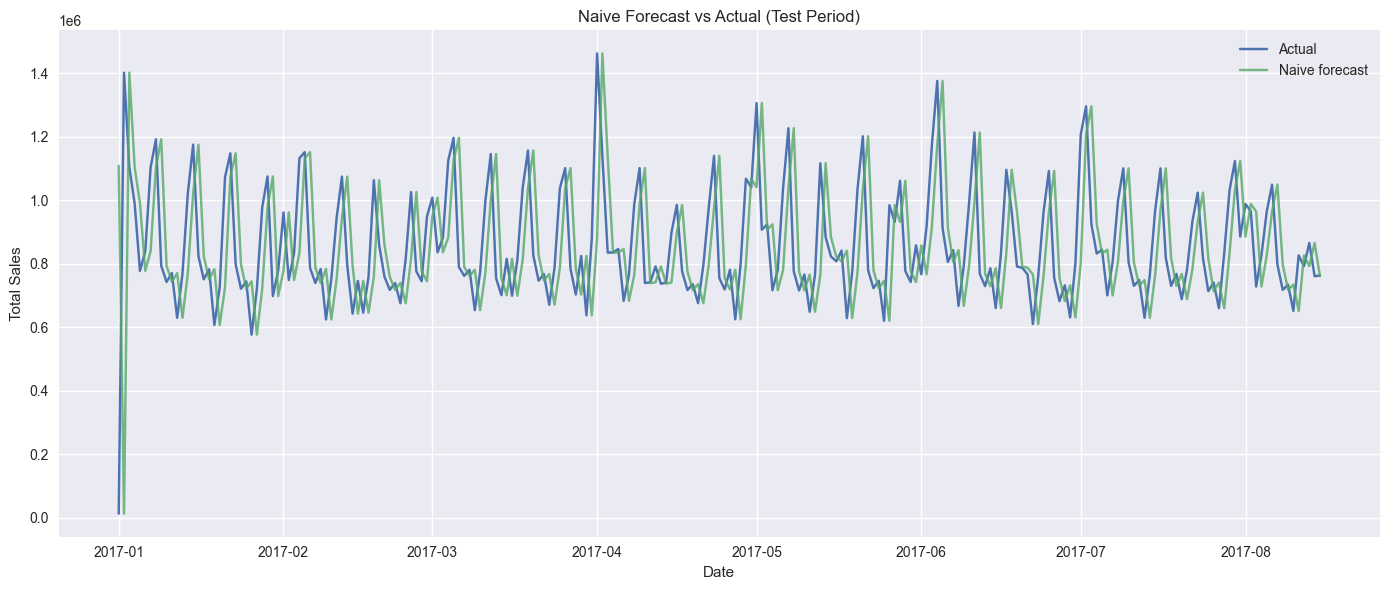

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(test_naive["date"][mask], y_true, label="Actual")
plt.plot(test_naive["date"][mask], y_pred_naive, label="Naive forecast", alpha=0.8)
plt.title("Naive Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()


### Naive Forecast — Visual Analysis

The naive model closely follows the overall dynamics
of the actual sales series, especially during stable periods.

However:

- It reacts with a one-day delay to sharp changes.
- Extreme peaks and drops are systematically underestimated or overestimated.

This behavior is expected, as the model does not account
for trend or seasonal effects.


### Naive Baseline — Discussion

Naive-модель даёт разумный ориентир качества:

- не использует никакой информации, кроме вчерашнего значения,
- не учитывает ни тренд, ни сезонность,
- тем не менее часто даёт неплохие результаты на краткосрочных горизонтах.

Дальнейшие модели имеют смысл только в том случае,
если они **существенно превосходят** данный baseline.


## 4. Baseline 2 — Moving Average

Вторая базовая модель — **скользящее среднее**:

> Прогноз на сегодня = среднее значение продаж за последние *N* дней.

Используем окно в **7 дней**, чтобы сгладить краткосрочный шум
и частично учесть недельную сезонность.


In [16]:
window = 7

daily_sales["ma_7"] = (
    daily_sales["total_sales"]
    .rolling(window=window)
    .mean()
    .shift(1)  # прогноз на сегодня = среднее за предыдущие N дней
)

test_ma = daily_sales[daily_sales["date"] >= split_date].copy()

y_true_ma = test_ma["total_sales"].values
y_pred_ma = test_ma["ma_7"].values

mask_ma = ~np.isnan(y_pred_ma)
y_true_ma = y_true_ma[mask_ma]
y_pred_ma = y_pred_ma[mask_ma]

mae_ma = mae(y_true_ma, y_pred_ma)
rmse_ma = rmse(y_true_ma, y_pred_ma)
mape_ma = mape(y_true_ma, y_pred_ma)

mae_ma, rmse_ma, mape_ma


(np.float64(143969.8193697478),
 np.float64(187128.3933095109),
 np.float64(53.24596109828934))

### Moving Average (7-day) Results

The 7-day moving average model smooths short-term fluctuations
and partially captures weekly seasonality.

Evaluation results:

- **MAE:** ~144k  
- **RMSE:** ~187k  
- **MAPE:** ~53%

Compared to the naive baseline, this model achieves
a noticeable reduction in all error metrics,
indicating better stability and noise reduction.


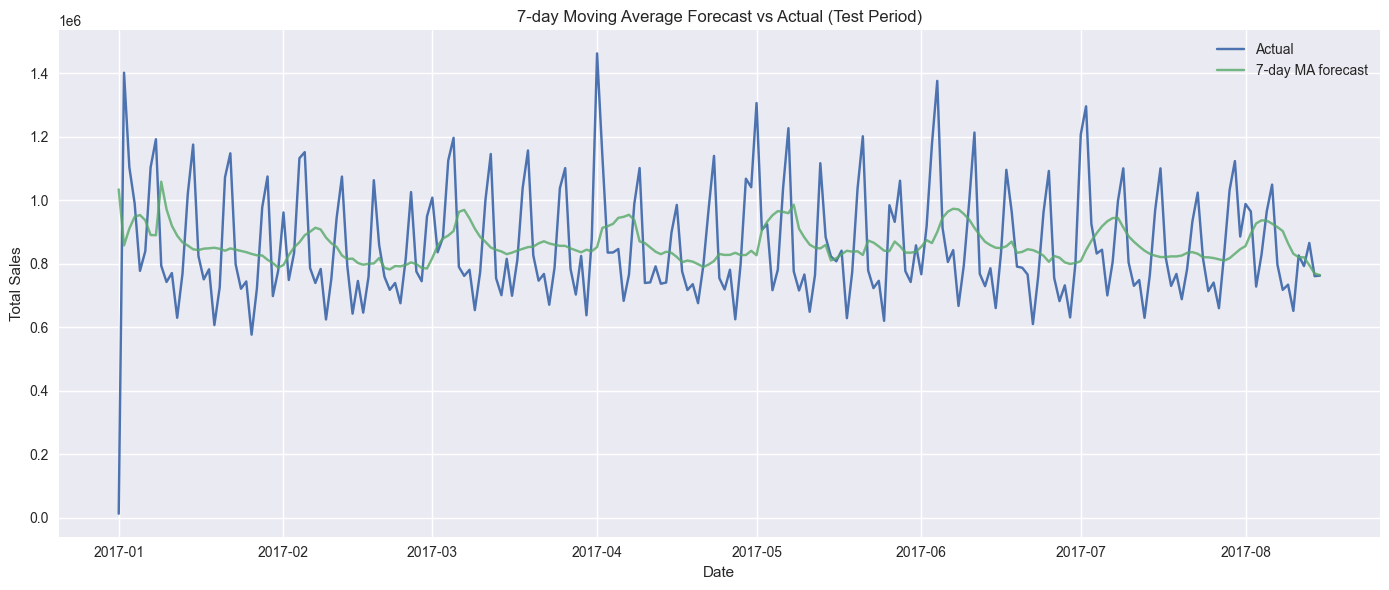

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(test_ma["date"][mask_ma], y_true_ma, label="Actual")
plt.plot(test_ma["date"][mask_ma], y_pred_ma, label="7-day MA forecast", alpha=0.8)
plt.title("7-day Moving Average Forecast vs Actual (Test Period)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.tight_layout()
plt.show()


### Moving Average Forecast — Visual Analysis

The moving average forecast produces a much smoother series
than the naive model.

Key observations:

- High-frequency noise is reduced.
- The model lags behind sudden demand spikes.
- Sharp peaks are systematically underestimated.

This highlights the classic trade-off between
smoothness and responsiveness in moving average models.


In [18]:
results = pd.DataFrame({
    "model": ["Naive (lag-1)", "Moving Average (7d)"],
    "MAE": [mae_naive, mae_ma],
    "RMSE": [rmse_naive, rmse_ma],
    "MAPE": [mape_naive, mape_ma],
})

results


,model,MAE,RMSE,MAPE
0,Naive (lag-1),162293.718578,221797.410096,58.106368
1,Moving Average (7d),143969.819370,187128.393310,53.245961


## Baseline Comparison — Summary

| Model | MAE | RMSE | MAPE |
|------|-----|------|------|
| Naive (lag-1) | ~162k | ~222k | ~58% |
| Moving Average (7d) | ~144k | ~187k | ~53% |

The 7-day moving average consistently outperforms
the naive baseline across all metrics.

These results establish a strong reference point:
any more advanced forecasting model should
demonstrate clear improvements over this baseline.


## 5. Baseline Comparison — Summary

Сравнение двух базовых моделей на отложенном периоде показывает:

- Наивный прогноз (предыдущее значение) задаёт минимальный ориентир качества.
- Скользящее среднее с окном в 7 дней сглаживает шум
  и частично учитывает недельную сезонность,
  что может приводить к снижению ошибок на спокойных участках ряда,
  но к запаздыванию реакции на резкие изменения.

Эти baseline-модели служат точкой отсчёта:
дальнейшие, более сложные подходы (ARIMA / ML-модели)
должны демонстрировать **лучшие значения MAE / RMSE / MAPE**
на том же тестовом периоде.


## Final Baseline Conclusions

- Simple baseline models already capture a large portion
  of the underlying sales dynamics.
- Weekly seasonality plays a significant role in demand patterns.
- Smoothing techniques improve stability but struggle
  with sudden demand shifts.
- These baselines provide a realistic lower bound
  for model performance.

In the next steps, more advanced models will be explored
to explicitly model trend and seasonality
and to improve forecast accuracy.
